# Options Screener

## Strategy
    1. Choose a stock and get the stock price
    2. Use same stock and view all off its options contracts
    3. Calculate Time to Expiration for each expiry
    4. Find Risk-Free Rate
    5. Scrape:
        a. All Call Premiums
        b. All Implied Volatilities 
        c. All Strike Prices
    6. Use Black-Scholes Equation to calculate theoretical option contract value
    7. Compare to call premiums listed and calculate difference
    8. Use this info to see if a given contract price is mispriced 

## Imports

In [1]:
import yfinance as yf
from scipy.stats import norm
import math
import datetime
import time
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import robin_stocks as rh

## Stock Price - $PLTR

In [ ]:
pltr = yf.Ticker('PLTR')

#pltr.info

hist = pltr.history(period="1wk")

price = hist.iloc[-1,3]
hist.head()

## Call Option Prices - $PLTR

In [ ]:
calls = yf.Ticker('PLTR').option_chain('2021-03-19').calls
calls.head()

## Options Dates

In [ ]:
dates = pd.to_datetime(yf.Ticker('PLTR').options)
dates

## Time to Expiry

In [ ]:
time_delta = dates - datetime.datetime.now()
t = (time_delta[0].total_seconds()/(60*60*24))/365
t
time_delta

## Black-Scholes Equation for One Expiry Date

In [ ]:
S = price
K = calls['strike']
r = 0.03
sigma = calls['impliedVolatility']

d1 = (np.log(S/K) + (r + (sigma**2)/2)*(t))/(sigma * np.sqrt(t))
d2 = d1 - sigma * np.sqrt(t)

calls['Black_Scholes'] = S * norm.cdf(d1) - norm.cdf(d2) * K * np.exp(-r * (t))

calls['delta'] = calls['Black_Scholes'] - calls['lastPrice']
calls.head()

## Black-Scholes Equation for All Expiry Dates

In [ ]:
S = price
K = calls['strike']
r = 0.03
sigma = calls['impliedVolatility']

time_to_expiry = []
for j in time_delta:
    time_to_expiry.append(j.total_seconds()/(60*60*24)/365)

dates_list = []
for each in dates:
    dates_list.append(each.strftime("%m/%d/%Y"))

dates_tte_dict = dict(zip(time_to_expiry,dates_list))
print(dates_tte_dict)
    


options_dict_list = []
for t in time_to_expiry:
    
    d1 = (np.log(S/K) + (r + (sigma**2)/2)*(t))/(sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)

    calls['Black_Scholes'] = S * norm.cdf(d1) - norm.cdf(d2) * K * np.exp(-r * (t))

    calls['delta'] = calls['Black_Scholes'] - calls['lastPrice']
    calls['timetoexpiry'] = t
    options_dict_list.append(calls.to_dict())

result = {}
for d in options_dict_list:
    result.update(d)

print(time_to_expiry)



options_dict = dict(zip(dates_list,options_dict_list))
pd.DataFrame.from_dict(options_dict, orient = 'index')
options_dict_list[5]

list_of_dataframes = []
for jes in options_dict_list:
    mmm = pd.DataFrame.from_dict(jes)
    list_of_dataframes.append(mmm)
list_of_dataframes[7]

all_options = pd.concat(list_of_dataframes)

# dataframes_list = [df.set_index('id') for df in list_of_dataframes]
# print(pd.concat(dfs, axis=1))
# # all_options = df = reduce(lambda left,right: pd.merge(left,right,on=['id']), dataframes_list)
all_options
# all_options.to_csv(r'/Users/andrewjfarrell1/Documents/JupyterNotebooks/paf.csv')
# sort = all_options.sort_values(by='delta', ascending=False)
# sort.head(33)

# below_5 = all_options[all_options["delta"] < 5]
# below_5.sort_values(by='delta',ascending=False)
all_options = all_options.reset_index(drop=True)
all_options["d8s"] = all_options['timetoexpiry'].map(dates_tte_dict)
all_options
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 22})
pltr = all_options[all_options.impliedVolatility != 0]
pltr.plot(x='d8s',y='delta',kind='bar')
pltr.plot(x='volume',y='delta',kind='scatter')


## Read Company Tickers

In [ ]:
companies = pd.read_csv("/Users/andrewjfarrell1/Documents/JupyterNotebooks/companylist.csv")
companies.head()

## AAPL Trial

In [ ]:
aapl = yf.Ticker('AAPL')

hist = aapl.history(period="1wk")

price = hist.iloc[-1,3]

calls = yf.Ticker('AAPL').option_chain('2021-10-15').calls

dates = pd.to_datetime(yf.Ticker('AAPL').options)

time_delta = dates - datetime.datetime.now()

S = price
K = calls['strike']
r = 0.03
sigma = calls['impliedVolatility']

time_to_expiry = []
for j in time_delta:
    time_to_expiry.append(j.total_seconds()/(60*60*24)/365)

dates_list = []
for each in dates:
    dates_list.append(each.strftime("%m/%d/%Y"))

dates_tte_dict = dict(zip(time_to_expiry,dates_list))

options_dict_list = []
for t in time_to_expiry:
    
    d1 = (np.log(S/K) + (r + (sigma**2)/2)*(t))/(sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)

    calls['Black_Scholes'] = S * norm.cdf(d1) - norm.cdf(d2) * K * np.exp(-r * (t))

    calls['delta'] = calls['Black_Scholes'] - calls['lastPrice']
    calls['timetoexpiry'] = t
    options_dict_list.append(calls.to_dict())

result = {}
for d in options_dict_list:
    result.update(d)

options_dict = dict(zip(dates_list,options_dict_list))
pd.DataFrame.from_dict(options_dict, orient = 'index')

list_of_dataframes = []
for jes in options_dict_list:
    mmm = pd.DataFrame.from_dict(jes)
    list_of_dataframes.append(mmm)

all_options = pd.concat(list_of_dataframes)
all_options = all_options.reset_index(drop=True)
all_options["d8s"] = all_options['timetoexpiry'].map(dates_tte_dict)

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 22})
aapl = all_options[all_options.impliedVolatility != 0]
aapl[1:60]
aapl.plot(x='d8s',y='delta',kind='bar')
# aapl.plot(x='volume',y='delta',kind='scatter')
plt.show()

## Define Function

In [2]:
def all_options(ticker):
    stock = yf.Ticker(ticker)
    hist = stock.history(period="1wk")
    price = hist.iloc[-1,3]
    calls = stock.option_chain('2022-01-21').calls
    dates = pd.to_datetime(stock.options)
    time_delta = dates - datetime.datetime.now()
    S = price
    K = calls['strike']
    r = 0.03
    sigma = calls['impliedVolatility']

    time_to_expiry = []
    for j in time_delta:
        time_to_expiry.append(j.total_seconds()/(60*60*24)/365)

    dates_list = []
    for each in dates:
        dates_list.append(each.strftime("%m/%d/%Y"))
    dates_tte_dict = dict(zip(time_to_expiry,dates_list))

    options_dict_list = []
    for t in time_to_expiry:
    
        d1 = (np.log(S/K) + (r + (sigma**2)/2)*(t))/(sigma * np.sqrt(t))
        d2 = d1 - sigma * np.sqrt(t)

        calls['Black_Scholes'] = S * norm.cdf(d1) - norm.cdf(d2) * K * np.exp(-r * (t))

        calls['delta'] = calls['Black_Scholes'] - calls['lastPrice']
        calls['timetoexpiry'] = t
        options_dict_list.append(calls.to_dict())

    result = {}
    for d in options_dict_list:
        result.update(d)

    options_dict = dict(zip(dates_list,options_dict_list))
    pd.DataFrame.from_dict(options_dict, orient = 'index')

    list_of_dataframes = []
    for jes in options_dict_list:
        mmm = pd.DataFrame.from_dict(jes)
        list_of_dataframes.append(mmm)

    all_options = pd.concat(list_of_dataframes)
    all_options = all_options.reset_index(drop=True)
    all_options["d8s"] = all_options['timetoexpiry'].map(dates_tte_dict)
    return all_options

## User Input

In [3]:
# # print("Enter Stock Ticker:")
# ticker = input()
# all_options('AAPL')
# ticker
ticker = input("Enter Stock Ticker: ")
# all_options(ticker)
# print("Enter a Stock Ticker: ")
# all_options(ticker)

Enter Stock Ticker: AAPL


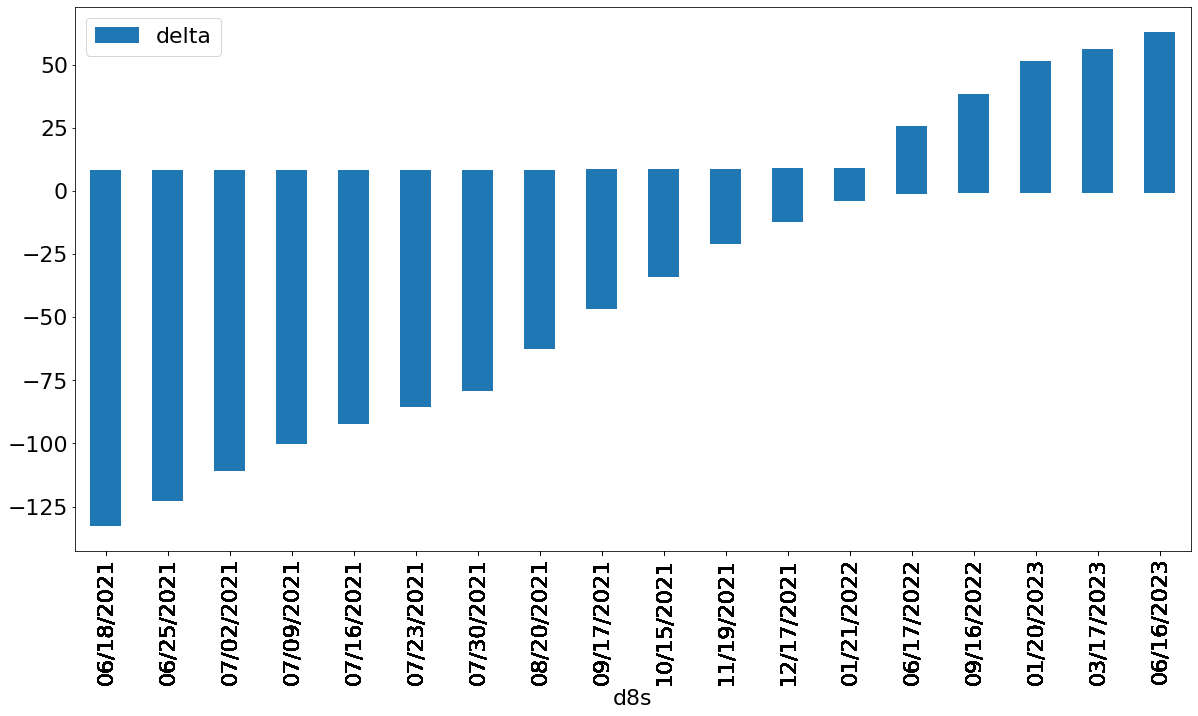

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,Black_Scholes,delta,timetoexpiry,d8s
0,AAPL220121C00025000,2021-06-16 13:30:05,25.00,105.15,106.75,107.40,0.000000,0.000000,2,10.0,1.009771,True,REGULAR,USD,106.811814,1.661814,0.001344,06/18/2021
1,AAPL220121C00027500,2021-06-16 18:30:04,27.50,101.75,104.45,104.60,0.000000,0.000000,1,269.0,0.921876,True,REGULAR,USD,104.311915,2.561915,0.001344,06/18/2021
2,AAPL220121C00028750,2021-05-19 19:09:14,28.75,95.35,102.95,103.65,0.000000,0.000000,1,130.0,0.911134,True,REGULAR,USD,103.061966,7.711966,0.001344,06/18/2021
3,AAPL220121C00030000,2021-06-14 13:50:48,30.00,98.95,101.95,102.20,0.000000,0.000000,20,54.0,0.900392,True,REGULAR,USD,101.812016,2.862016,0.001344,06/18/2021
4,AAPL220121C00031250,2021-05-06 18:54:00,31.25,97.50,94.55,94.80,0.000000,0.000000,991,40.0,0.000010,True,REGULAR,USD,100.562066,3.062066,0.001344,06/18/2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2614,AAPL220121C00540000,2020-08-28 19:34:12,540.00,75.92,73.85,75.40,-0.380005,-0.498040,11,2721.0,3.049929,False,REGULAR,USD,124.028669,48.108669,1.995865,06/16/2023
2622,AAPL220121C00700000,2020-08-28 19:59:58,700.00,37.35,36.15,37.35,0.199997,0.538350,22,968.0,2.224187,False,REGULAR,USD,100.451082,63.101082,1.995865,06/16/2023
2624,AAPL220121C00740000,2020-08-28 19:54:01,740.00,31.98,30.70,31.90,-0.020000,-0.062501,55,256.0,2.120427,False,REGULAR,USD,95.051149,63.071149,1.995865,06/16/2023
2626,AAPL220121C00900000,2020-08-28 19:26:55,900.00,18.13,17.35,18.40,0.029999,0.165739,5,NaN,1.868592,False,REGULAR,USD,78.141628,60.011628,1.995865,06/16/2023


In [4]:
mko1 = all_options(ticker)
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 22})
mko = mko1[mko1.impliedVolatility != 0]
mko.plot(x='d8s',y='delta',kind='bar')
plt.show()
# # mko.plot(x='volume',y='delta',kind='scatter')
mko